In [1]:
from functions import *

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import pandas as pd
import verde as vd

from skimage.feature import blob_log
import skimage
import scipy.signal as signal

import mplstereonet as mpl


microm2m = 1.0E-6
m2microm = 1.0E6
# plt.rcParams["figure.figsize"] = (10,10)

In [2]:
# load the matrix data
mat_contents = np.loadtxt('Bz_synthetic.csv', delimiter=',')


shape = np.shape(mat_contents) # grid shape
data = mat_contents # 2D Bz data

In [3]:
data = np.reshape(data, (np.size(data),1))
data_2D = np.reshape(data, shape)

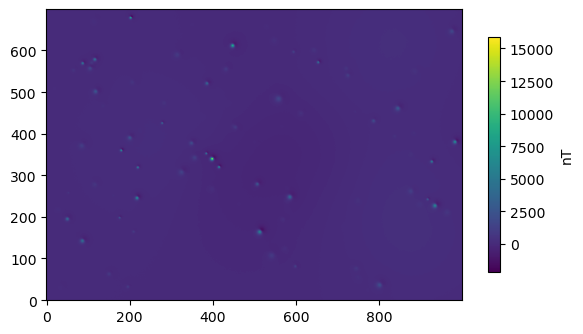

In [4]:
plt.figure(figsize=(6,5))
plt.imshow(data_2D*10**9, cmap='viridis')
plt.colorbar(shrink=0.5, label='nT')
plt.gca().invert_yaxis()

plt.tight_layout()

In [5]:
grid_spacing = pd.read_csv('grid_spacing.csv')
x_step = float(grid_spacing['x step (m)'])
y_step = float(grid_spacing['y step (m)'])
sensor_sample_distance = float(grid_spacing['sensor distance sample (m)'])

area = (0, (np.shape(data_2D)[0])*x_step, 0, (np.shape(data_2D)[1])*y_step)
z = - abs(sensor_sample_distance)

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A

In [6]:
data_2D_orig = np.copy(data_2D)
trend = vd.Trend(degree=12).fit((X.ravel(), Y.ravel()), data_2D.ravel())

In [7]:
data_2D -= trend.predict((X.ravel(), Y.ravel())).reshape(shape)

In [8]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

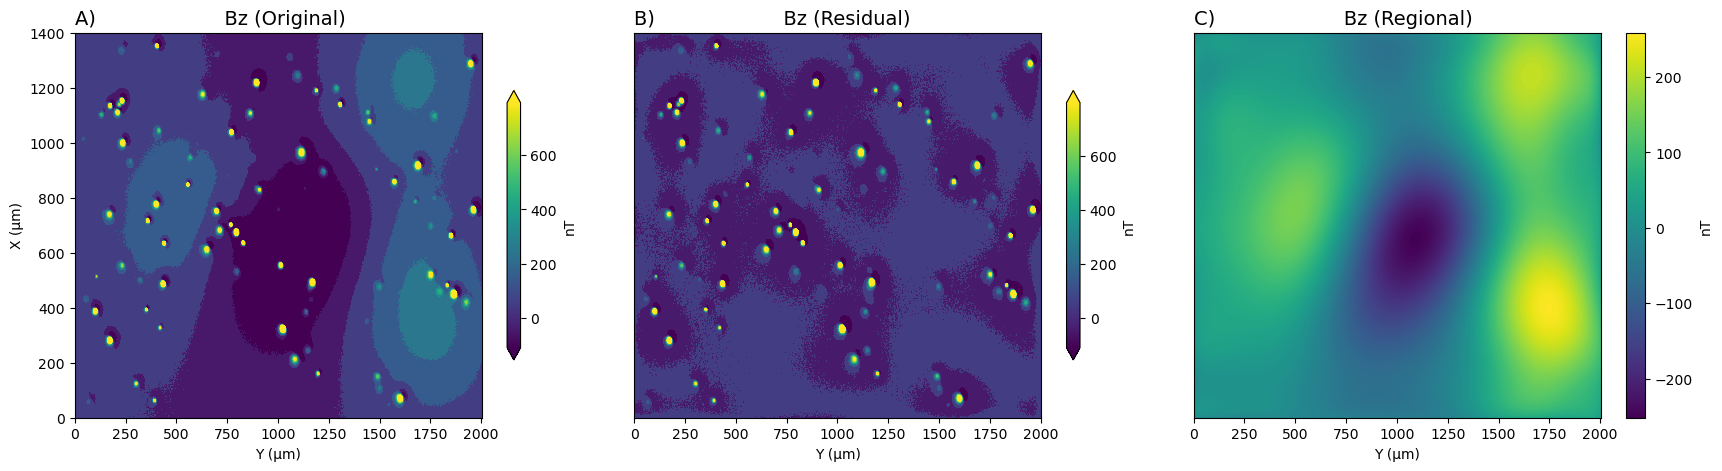

In [9]:
# create extent colorbars 
vmin1=np.min(data_2D_orig*10**9) * 0.05
vmax1=np.max(data_2D_orig*10**9) * 0.05
vmin2=np.min(data_2D*10**9) * 0.05
vmax2=np.max(data_2D*10**9) * 0.05

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(data_2D_orig*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)

img2 = plt.imshow(data_2D*10**9, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

regional_2D = (data_2D_orig-data_2D)

img3 = plt.imshow(regional_2D*10**9, cmap='viridis')
img3.axes.get_xaxis().set_visible(False)
img3.axes.get_yaxis().set_visible(False)


#######
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(21,5))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=200, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                     Bz (Original)', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot residual data
ax2_plot = ax2.contourf(x_plot, y_plot, data_2D*10**9, levels=200, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='nT', extend='both', shrink=0.7)
ax2.set_title('B)                     Bz (Residual)', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)

ax3_plot = ax3.contourf(x_plot, y_plot, regional_2D*10**9, levels=200, cmap='viridis')
plt.colorbar(img3, ax=ax3, label='nT')#, shrink=0.7)
ax3.set_title('C)                     Bz (Regional)', fontsize=14, loc='left')
ax3.set_xlabel('Y (µm)', fontsize=10)


ax2.set_yticks([])
ax3.set_yticks([])
fig.subplots_adjust(wspace=0.1)

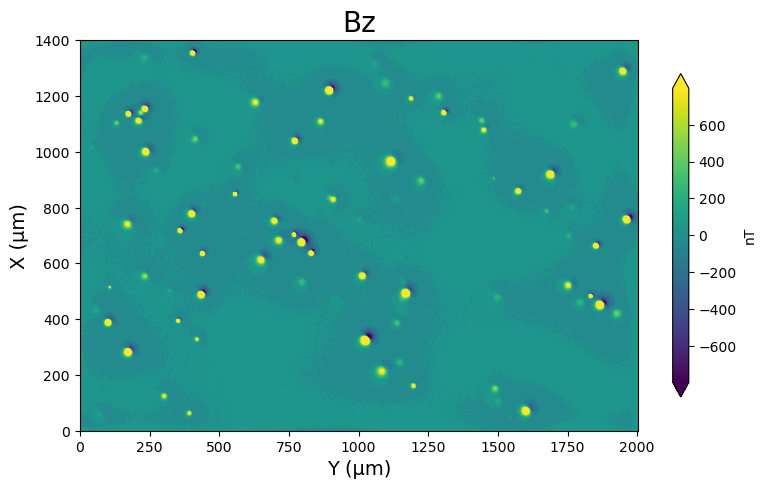

In [10]:
# Change the colorbar scale
# Plot data from the forward model

vmin=np.min(data_2D*10**9) * 0.05
vmax=np.max(data_2D*10**9) * 0.05

if abs(vmax) > abs(vmin):
    vmax = vmax
    vmin = -1*vmax
else:
    vmax = abs(vmin)
    vmin = vmin

plt.figure(figsize=(9,6))
fig = plt.imshow(data_2D*10**9, cmap='viridis')
plt.clim(vmin, vmax)
plt.contourf(x_plot, y_plot, data_2D*10**9, levels=300, cmap='viridis', 
             vmin=vmin, vmax=vmax, extend='both')
color_bar = plt.colorbar(fig, label='nT', extend='both', shrink=0.7)
plt.gca().invert_yaxis()


plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.show()

In [11]:
X_2D = np.reshape(X, shape)
Y_2D = np.reshape(Y, shape)
Z_2D = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(data_2D, X_2D, Y_2D)

In [12]:
# X_derivative_FFT = x_derivative_fft(data_2D, wx, order=1)
# Y_derivative_FFT = y_derivative_fft(data_2D, wy, order=1)
# X_derivative_FFT = z_derivative_fft(data_2D, wz, order=1)

# # calculating derivatives (x and y) using Finite Differences (FD)
# X_derivative_FD, Y_derivative_FD = (derivative_fd(data_2D, X_2D, Y_2D, order=1))

In [13]:
# # plot FFT derivatives
# fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

# ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], X_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('∂B/∂x (FFT)', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# ax2_plot  = ax2.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('∂B/∂y (FFT)', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

# ax3_plot  = ax3.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
# ax3.set_title('∂B/∂z (FFT)', fontsize=14)
# ax3.set_xlabel('Y (µm)', fontsize=10)
# ax3.set_ylabel('X (µm)', fontsize=10)

In [14]:
# # plot FD derivatives
# fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], X_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('∂B/∂x (FD)', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Y_derivative_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('∂B/∂y (FD)', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

In [15]:
# # Calculating the horizontal gradient (GH) using FFT e FD

# Horiz_Grad_FD = Horiz_Grad(Y_derivative_FD , X_derivative_FD)
# Horiz_Grad_FFT = Horiz_Grad(Y_derivative_FFT, X_derivative_FFT)

In [16]:
# fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# # plot FD horizontal gradient 
# ax1_plot  = ax1.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FD[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('GH-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# # plot FFT horizontal gradient 
# ax2_plot = ax2.contourf(x_plot[::2], y_plot[::2], Horiz_Grad_FFT[::2]*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('GH-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

In [17]:
# upward_continuation filtering --> to remove high frequency noise
height = 2.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(data_2D, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(data_2D, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(data_2D, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

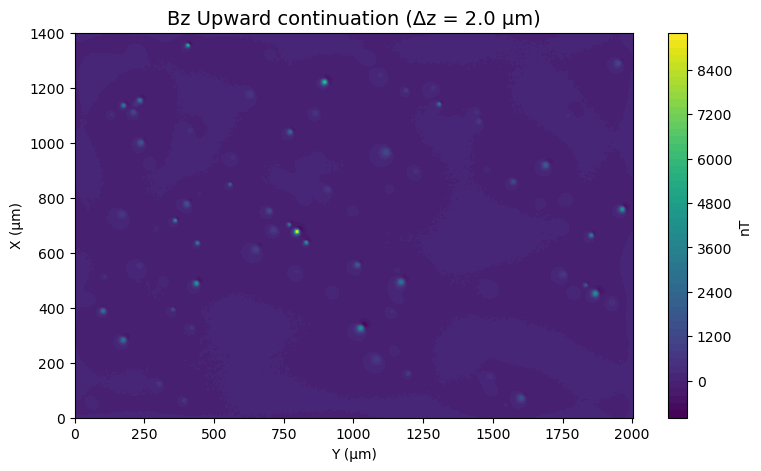

In [18]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)

In [19]:
# New derivatives by FFT
Y_derivative_FFT = y_derivative_fft(upward, wy)
X_derivative_FFT = x_derivative_fft(upward, wx)
Z_derivative_FFT = z_derivative_fft(upward, wz)

In [20]:
# # Plot derivatives by FFT (after upward continuation)

# fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

# ax1_plot  = ax1.contourf(x_plot, y_plot, X_derivative_FFT*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('∂B/∂x (FFT)', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# ax2_plot  = ax2.contourf(x_plot, y_plot, Y_derivative_FFT*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('∂B/∂y (FFT)', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

# ax3_plot  = ax3.contourf(x_plot, y_plot, Z_derivative_FFT*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
# ax3.set_title('∂B/∂z (FFT)', fontsize=14)
# ax3.set_xlabel('Y (µm)', fontsize=10)
# ax3.set_ylabel('X (µm)', fontsize=10)

In [21]:
# New derivatives by FD
X_derivative_FD, Y_derivative_FD = (derivative_fd(upward, X_2D, Y_2D))
Z_derivative_FD = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

In [22]:
# # Plot derivatives by FD (after upward continuation)
# fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

# ax1_plot  = ax1.contourf(x_plot, y_plot, X_derivative_FD*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('∂B/∂x (FD)', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# ax2_plot = ax2.contourf(x_plot, y_plot, Y_derivative_FD*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('∂B/∂y (FD)', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

# ax3_plot = ax3.contourf(x_plot, y_plot, Z_derivative_FD*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax3_plot, ax=ax3, label='nT/µm')
# ax3.set_title('∂B/∂z (FD)', fontsize=20)
# ax3.set_xlabel('Y (µm)', fontsize=14)
# ax3.set_ylabel('X (µm)', fontsize=14)

In [23]:
# total gradient data
Total_Grad_FD = Total_Grad(Y_derivative_FD , X_derivative_FD, Z_derivative_FD)
Total_Grad_FFT = Total_Grad(Y_derivative_FFT, X_derivative_FFT, Z_derivative_FFT)

In [24]:
# fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,5))

# # plot FD total gradient 
# ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
# ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
# ax1.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)

# # plot FFT total gradient 
# ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FFT*10**3, levels=50, cmap='viridis')
# plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
# ax2.set_title('TG-FFT'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$+(∂B/∂z)$^2$)$^1$$^/$$^2$', fontsize=14)
# ax2.set_xlabel('Y (µm)', fontsize=10)
# ax2.set_ylabel('X (µm)', fontsize=10)

# Euler solver

Text(0, 0.5, 'Count')

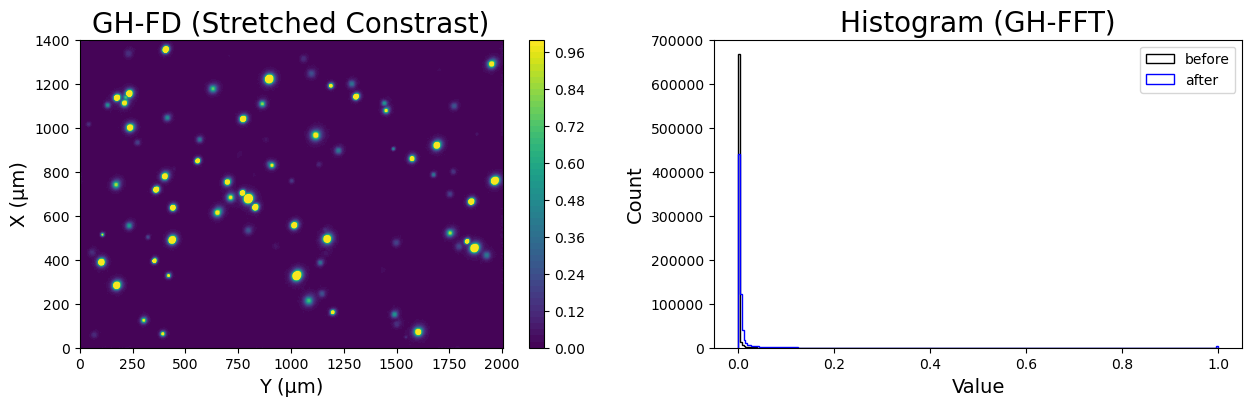

In [25]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


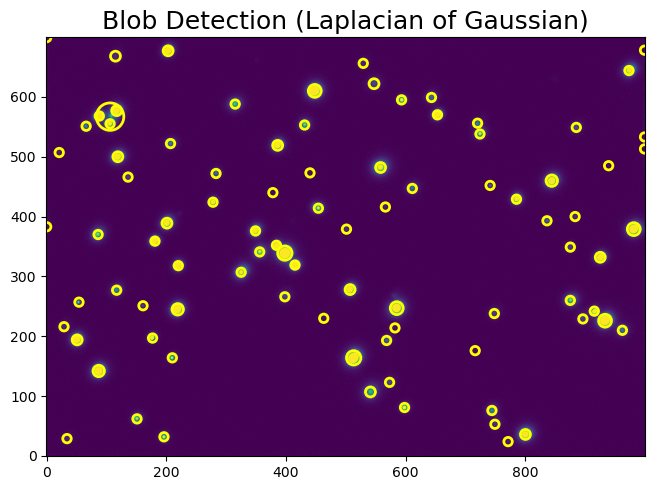

Sources found  =  84


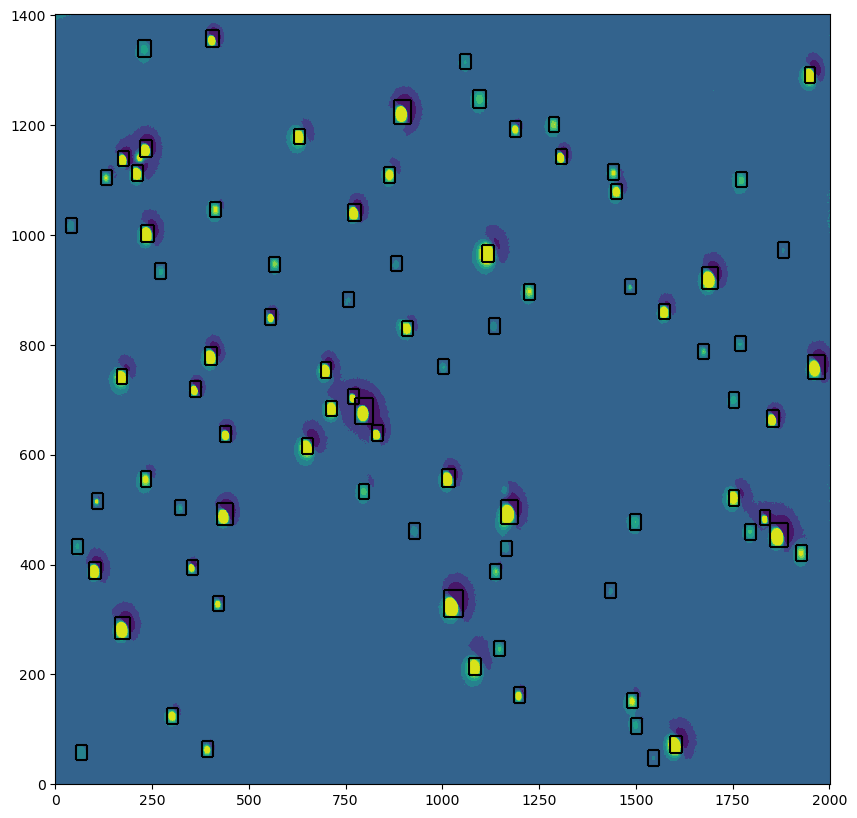

In [49]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.01, min_sigma=5, 
                                              max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.0)

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_2D, Y_2D, Z_2D, upward,
                                                                     X_derivative_FD, Y_derivative_FD, Z_derivative_FD,
                                                                     delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(data_2D, (0.5,99.5))
view = skimage.exposure.rescale_intensity(data_2D, in_range=(perc_min, perc_max))
euler_windows_view(X_2D, Y_2D, Z_2D, view, filtered_euler_windows_FD, show_windows=False, color='k')


print('Sources found  = ', np.shape(filtered_euler_windows_FD)[0])

Euler Solutions:
      Xc (µm)    Yc (µm)  Zc (µm)
0   1357.9319   407.4104   1.2680
1    720.0198   362.3637   1.2681
2   1223.7340   897.8956   6.1803
3    637.9158   441.4428   2.2437
4    491.7084   438.4398   5.1975
..        ...        ...      ...
79   951.6760   884.0275  12.3782
80   356.7823  1435.8402  11.5811
81   972.1222  1883.9859   3.4738
82   888.4708   760.0238  11.5870
83   417.4915  1170.9240  20.2250

[84 rows x 3 columns]

Original Positions:
    Xc (µm)  Yc (µm)  Zc (µm)
0    1222.0    897.0      6.0
1     557.0    236.0     12.0
2     523.0   1755.0     13.0
3     329.0   1028.0      9.0
4     496.0   1172.0     10.0
..      ...      ...      ...
95   1041.0    774.0      5.0
96    436.0     61.0     17.0
97    217.0   1086.0     19.0
98    719.0    362.0      1.0
99    898.0   1226.0     14.0

[100 rows x 3 columns]



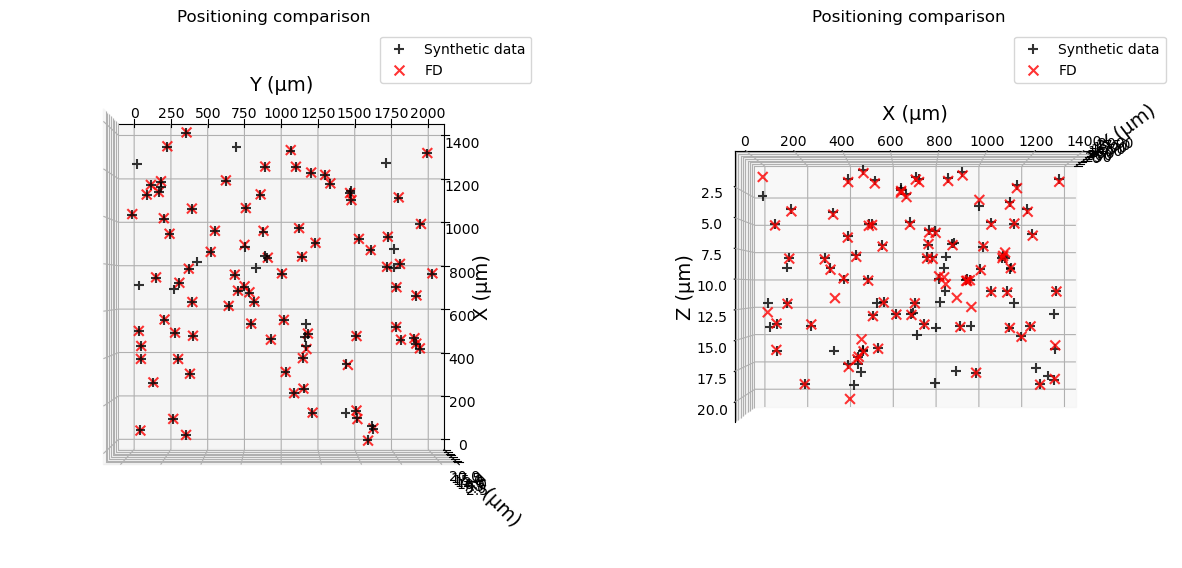

In [50]:
# Read model parameter to compare
model_par = pd.read_csv('model_parameters.csv')

D = model_par['Dec (°)']
I = model_par['Inc (°)']
M = model_par['Mag (A/m)']
R = model_par['Radii (µm)']*microm2m

Xc = model_par['Xc (µm)']*microm2m
Yc = model_par['Yc (µm)']*microm2m
Zc = model_par['Zc (µm)']*microm2m
###############################################

import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2)
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()





# Magnetic inversion using lest square method

In [51]:
# set the noise level as the measurement standart deviation
noise_std_dev = 15.0e-9 # nT for the 'fixed method'

In [52]:
# # Magnetic inversion using FD euler positions and magnetic data before the upward continuation
# mx_FD_least, my_FD_least, mz_FD_least, A_FD_least, forward_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, data)
# D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True, show_mean=True, show_alpha95=True)

# #calculate momentum
# momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


# #Inversion uncertainties
# # sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
# sigma_noise = noise_std_dev
# sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, A_FD_least, mx_FD_least, my_FD_least, mz_FD_least)

# import pandas as pd
# df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
#                         '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
#                         'Inc (°)': (np.round(I_FD_least, decimals=4)),
#                         '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
#                         'm  ($A \cdot m^2$)':  (momentum_FD_least),
#                         '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
#                         'Xc (µm)': Xc_FD*m2microm,
#                         'Yc (µm)': Yc_FD*m2microm,
#                         'Zc (µm)': Zc_FD*m2microm
                        
#                        })

# df.head(5)

In [53]:
### Windows
windows_dataframe = window_least_square_solver(filtered_euler_windows_FD, X_2D, Y_2D, Z_2D, data_2D, upward, delta_z,
                                               X_derivative_FD, Y_derivative_FD, Z_derivative_FD, noise_std_dev, 
                                               structural_index=3, show=False)

### Windows with different upward level ###
# windows_dataframe = window_least_square_solver_new(filtered_euler_windows_FD, X_2D, Y_2D, Z_2D, data_2D, noise_std_dev,
#                                                    delta_z_list=np.linspace(2.0, 5.1, 15), show=False)


In [54]:
windows_dataframe.head()

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),mx ($A \cdot m^2$),my ($A \cdot m^2$),mz ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm),$R^2$
0,40.1027,0.0440,41.8824,0.0279,1.908938e-14,9.623200e-18,1.087090e-14,9.155032e-15,1.274415e-14,1357.931905,407.410410,1.267994,0.998127
1,49.0909,0.0599,40.0783,0.0385,1.369102e-14,9.739597e-18,6.860252e-15,7.917145e-15,8.814753e-15,720.019796,362.363750,1.268118,0.998100
2,48.7292,0.0490,58.1014,0.0240,7.742315e-14,2.788745e-17,2.698613e-14,3.074930e-14,6.573106e-14,1223.734023,897.895638,6.180344,0.999740
3,35.3968,0.1112,56.6035,0.0563,1.377376e-14,1.182552e-17,6.180129e-15,4.391470e-15,1.149945e-14,637.915833,441.442825,2.243747,0.998777
4,40.9243,0.0514,46.4101,0.0309,4.701856e-14,2.494596e-17,2.449493e-14,2.123640e-14,3.405524e-14,491.708397,438.439843,5.197466,0.999644


# Model x Recoverd Data Comparison

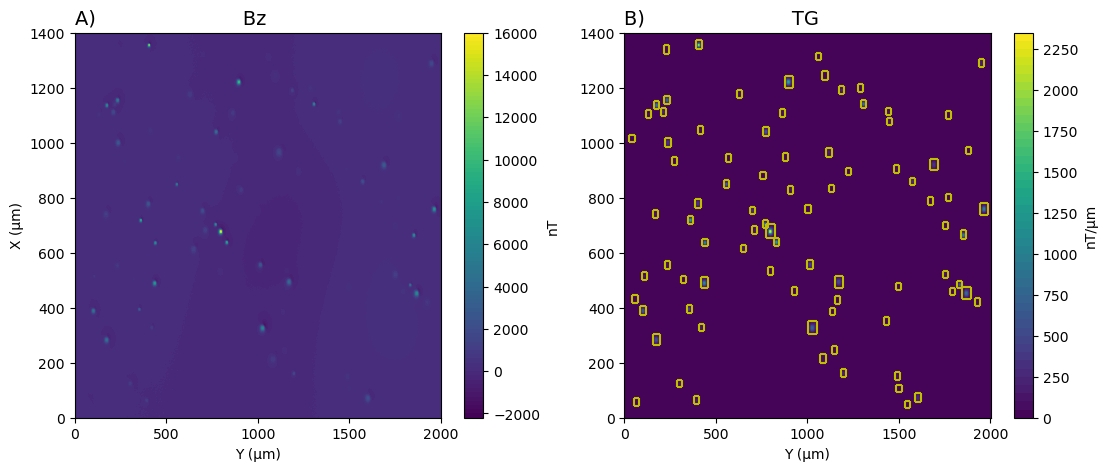

In [55]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=100, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('A)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title('B)                        TG', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)


In [56]:
D_FD_least = np.array(windows_dataframe[r'Dec (°)'])
sigma_D_FD_least = np.array(windows_dataframe[r'$\sigma D$ (°)'])

I_FD_least = np.array(windows_dataframe[r'Inc (°)'])
sigma_I_FD_least = np.array(windows_dataframe[r'$\sigma I$ (°)'])

momentum_FD_least = np.array(windows_dataframe[r'm  ($A \cdot m^2$)'])
sigma_m_FD_least = np.array(windows_dataframe[r'$\sigma m$ ($A \cdot m^2$)'])

Xc_FD = np.array(windows_dataframe[r'Xc (µm)'])
Yc_FD = np.array(windows_dataframe[r'Yc (µm)'])
Zc_FD = np.array(windows_dataframe[r'Zc (µm)'])

R2 = np.array(windows_dataframe[r'$R^2$'])

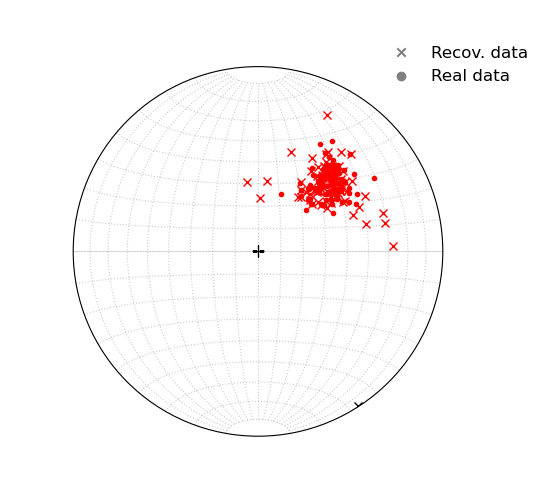

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')

for w in range (np.size(D)):
    if I[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        ax.line(np.absolute(I[w]), D[w], color=color, marker=symbol)

    else:
        ax.line(np.absolute(I[w]), D[w],  color=color, marker=symbol)

        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        ax.line(np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

    else:
        ax.line( np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

ax.line(90,90, marker='+', color='k', markersize=8) # center mark
ax.set_azimuth_ticks([])
ax.grid(which='both', linestyle=':', color='gray', alpha=0.4)

ax.scatter([],[], marker='x', color='gray', label='Recov. data')
ax.scatter([],[], marker='o', color='gray', label='Real data')

ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=12)

ax.plot();

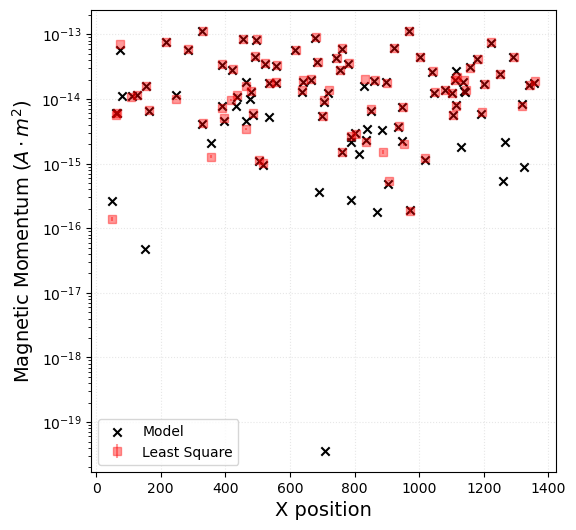

In [58]:
sources = np.copy(Xc_FD)

real=(np.array(M)*4/3*np.pi*np.array(R)**3)

plt.figure(figsize=(6,6))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')


plt.scatter(np.array(Xc*m2microm), real, marker='x', color='k', label='Model')

plt.legend()
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')

## Forward Model and Residuals

### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

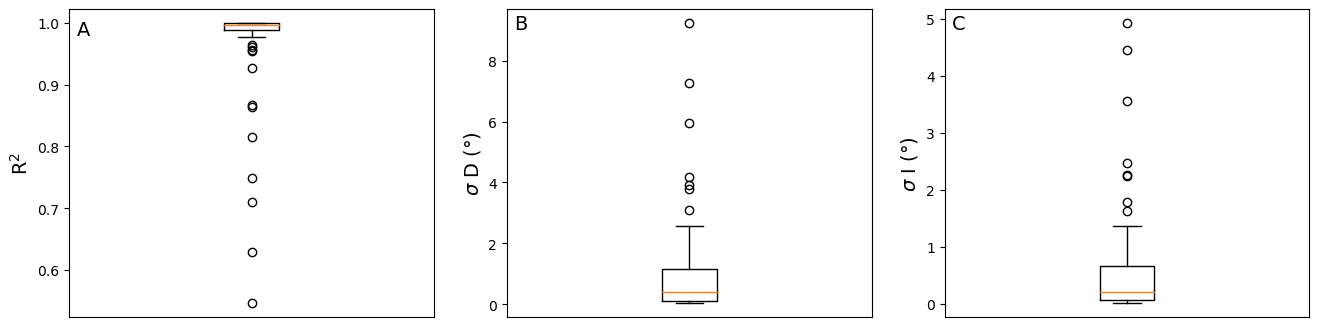

In [59]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(R2)
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = R2.max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(sigma_D_FD_least)
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = sigma_D_FD_least.max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(sigma_I_FD_least)
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = sigma_I_FD_least.max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()


Mean direction: 46.41398853837354 / 46.51290192874678
Alpha_95 cone =   2.089032550065379°


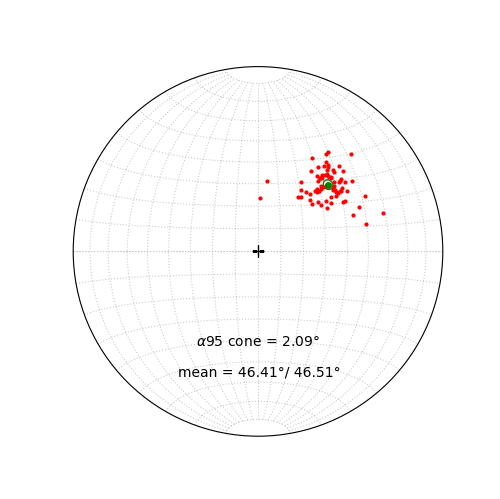

filtered sources =  76


In [60]:
# index = ((df_final['R2']>=-np.inf) & (df_final['sigma D (°)']<=np.inf) & (df_final['sigma I (°)']<=np.inf)) # raw data
cut_off_R2 = 0.95
index = ((windows_dataframe[r'$R^2$']>=cut_off_R2)) #& (df_final['sigma D (°)']<=5) & (df_final['sigma I (°)']<=3)) # filtered data
h=windows_dataframe[index]



D_filtered, I_filtered = directions(np.array(h[r'mx  ($A \cdot m^2$)']), np.array(h[r'my  ($A \cdot m^2$)']), 
                                    np.array(h[r'mz  ($A \cdot m^2$)']), plot=True, show_mean=True, show_alpha95=True)

mx_filtered = np.array(h[r'mx  ($A \cdot m^2$)'])
my_filtered = np.array(h[r'my  ($A \cdot m^2$)'])
mz_filtered = np.array(h[r'mz  ($A \cdot m^2$)'])

print('filtered sources = ', np.size(D_filtered))

#### Momentum Recovered

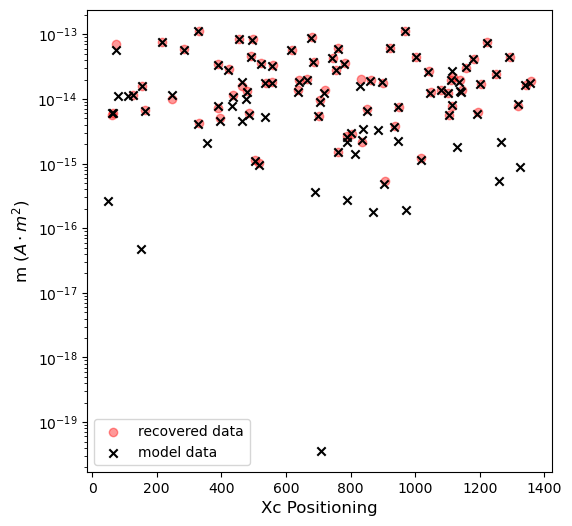

In [61]:
moment_real = M*4/3*np.pi*R**3

plt.figure(figsize=(6,6))
plt.scatter(h[r'Xc (µm)'], h[r'm  ($A \cdot m^2$)'], label='recovered data', alpha=0.4, color='r')



plt.scatter(Xc*m2microm, moment_real, marker='x', label='model data', color='k')


plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $(A \cdot m^{2})$', fontsize=12)

plt.legend(loc='best')

plt.yscale('log')


# Article Figures

### Fisrt Figure

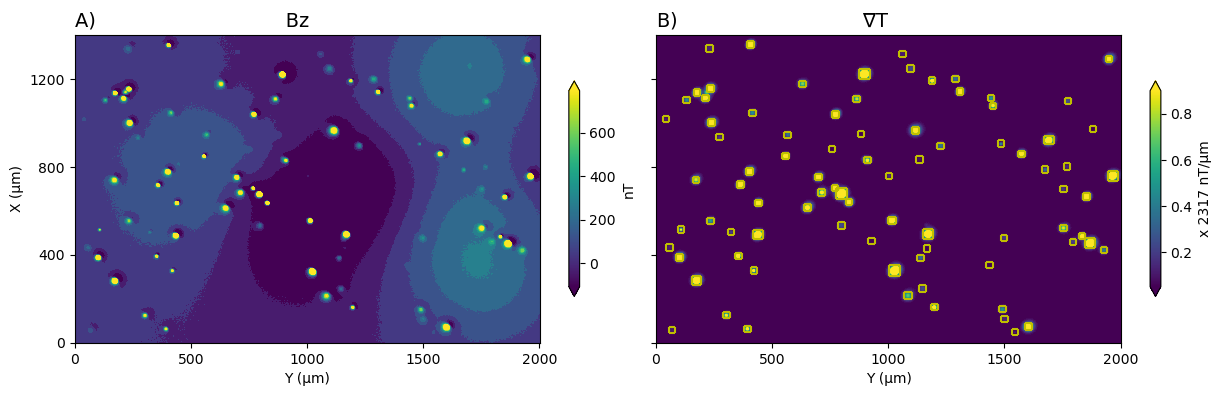

In [62]:
# create extent colorbars 
vmin1=np.min(data_2D_orig*10**9) * 0.05
vmax1=np.max(data_2D_orig*10**9) * 0.05
vmin2=0.05
vmax2=np.max(stretched_image) * 0.9

plt.figure(figsize=(.001,.001))
img1 = plt.imshow(data_2D*10**9, cmap='viridis')
img1.set_clim(vmin1, vmax1)

img2 = plt.imshow(Total_Grad_FD*10**3, cmap='viridis')
img2.set_clim(vmin2, vmax2)
img2.axes.get_xaxis().set_visible(False)
img2.axes.get_yaxis().set_visible(False)

scale_max = int(np.max(Total_Grad_FD*10**3))





#### Real Figure ####
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

# plot original data
ax1_plot = ax1.contourf(x_plot, y_plot, data_2D_orig*10**9, levels=300, cmap='viridis', 
             vmin=vmin1, vmax=vmax1, extend='both')
color_bar1 = plt.colorbar(img1, ax=ax1, label='nT', extend='both', shrink=0.7)
ax1.set_title('A)                               Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)


# plot total gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis',
                       vmin=vmin2, vmax=vmax2, extend='both')
color_bar2 = plt.colorbar(img2, ax=ax2, label='x %s nT/µm'%(str(scale_max)), extend='both', shrink=0.7)
ax2.set_title(r'B)                              $\nabla$T', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)


# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(filtered_euler_windows_FD)[0]):
    x1 = int(filtered_euler_windows_FD[i,0]) * x_step
    x2 = int(filtered_euler_windows_FD[i,1]) * x_step
    y1 = int(filtered_euler_windows_FD[i,2]) * y_step
    y2 = int(filtered_euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)

ax1.set_xticks([0, 500, 1000, 1500, 2000])
ax1.set_yticks([0, 400, 800, 1200])
ax2.set_xticks([0, 500, 1000, 1500, 2000])
ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])

fig.subplots_adjust(wspace=0.0)
    
image_name = 'ComplexSynthetic'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

### Second Figure

In [63]:
w_fd = np.copy(filtered_euler_windows_FD)

nan_array = np.empty(len(D))
nan_array[:] = np.nan

df_win = pd.DataFrame(data={'x1 wind (µm)':  nan_array,
                            'x2 wind (µm)':  nan_array,
                            'y1 wind (µm)':  nan_array,
                            'y2 wind (µm)':  nan_array,
                            'Xc real (µm)':  nan_array,
                            'Yc real (µm)':  nan_array,
                            'Zc real (µm)':  nan_array,
                            'R real (µm)':  nan_array,                            
                            'm  real (Am2)': nan_array,
                            'D  real (°)': nan_array,
                            'I  real (°)': nan_array,                            
                            'R2': nan_array,
                            'm  recov (Am2)': nan_array,
                            'D  recov (°)': nan_array,
                            'I  recov (°)': nan_array,
                            'm residual (%)': nan_array,
                            'D residual (°)': nan_array,
                            'I residual (°)': nan_array,
                            'Angular deviation (°)': nan_array
                             })
                           
                           
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)

for j in range(len(D)):
    for k in range(len(D_FD_least)):
        for window in w_fd:
            if ( 
               ( (Xc[j]*m2microm )>(window[0]*x_step) ) and ( (Xc[j]*m2microm )<(window[1]*x_step) ) and 
               ( (Yc[j]*m2microm )>(window[2]*y_step) ) and ( (Yc[j]*m2microm )<(window[3]*y_step) ) and
               ( (Xc_FD[k])>(window[0]*x_step) ) and ( (Xc_FD[k])<(window[1]*x_step) ) and 
               ( (Yc_FD[k] )>(window[2]*y_step)) and ( (Yc_FD[k])<(window[3]*y_step) ) 
               ):
               
                # save the windows
                df_win['x1 wind (µm)'][j] = int(window[0]*x_step)
                df_win['x2 wind (µm)'][j] = int(window[1]*x_step)
                df_win['y1 wind (µm)'][j] = int(window[2]*y_step)
                df_win['y2 wind (µm)'][j] = int(window[3]*y_step)

                # save real and model parameter of sources found by the source_finder function
                df_win['Xc real (µm)'][j] = Xc[j]*m2microm
                df_win['Yc real (µm)'][j] = Yc[j]*m2microm
                df_win['Zc real (µm)'][j] = Zc[j]*m2microm
                df_win['R real (µm)'][j] = R[j]*m2microm
                df_win['D  real (°)'][j] = D[j]
                df_win['I  real (°)'][j] = I[j]
                df_win['m  real (Am2)'][j] = moment_real[j]
                df_win['D  recov (°)'][j] = D_FD_least[k]
                df_win['I  recov (°)'][j] = I_FD_least[k]
                df_win['m  recov (Am2)'][j] = momentum_FD_least[k]
                df_win['R2'][j] = R2[k]
                
                # calculate de difference in (%)
                df_win['D residual (°)'][j] = ((D[j] - D_FD_least[k]) )
                df_win['I residual (°)'][j] =  ((I[j] - I_FD_least[k]) )
                df_win['m residual (%)'][j] =  ((moment_real[j] - momentum_FD_least[k]) /(moment_real[j]))*100
                df_win['Angular deviation (°)'][j] = np.degrees(mpl.angular_distance(mpl.line(I[j], D[j]),
                                                                                     mpl.line(I_FD_least[k], D_FD_least[k]),
                                                                                     bidirectional=False) )
  





In [64]:
df_win.head(-5)

# plt.scatter(np.array(df_win['Angular deviation (°)']), np.array(df_win['R2']))

,x1 wind (µm),x2 wind (µm),y1 wind (µm),y2 wind (µm),Xc real (µm),Yc real (µm),Zc real (µm),R real (µm),m real (Am2),D real (°),I real (°),R2,m recov (Am2),D recov (°),I recov (°),m residual (%),D residual (°),I residual (°),Angular deviation (°)
0,1201.0,1245.0,875.0,919.0,1222.0,897.0,6.0,0.852810,7.487625e-14,48.529820,57.994763,0.999740,7.742315e-14,48.7292,58.1014,-3.401470,-0.199380,-0.106637,0.150015
1,541.0,569.0,220.0,248.0,557.0,236.0,12.0,0.580031,1.798380e-14,42.353039,40.105949,0.999061,1.810840e-14,42.3603,39.9082,-0.692857,-0.007261,0.197749,0.197827
2,507.0,535.0,1739.0,1767.0,523.0,1755.0,13.0,0.695748,3.511826e-14,64.446169,40.774626,0.999400,3.548755e-14,66.4304,40.0211,-1.051565,-1.984231,0.753526,1.688512
3,304.0,353.0,1004.0,1052.0,329.0,1028.0,9.0,0.948179,1.114233e-13,42.983263,36.416251,0.999881,1.139506e-13,43.1908,36.4266,-2.268199,-0.207537,-0.010349,0.167320
4,473.0,517.0,1150.0,1194.0,496.0,1172.0,10.0,0.873512,8.190719e-14,45.876879,51.923261,0.997834,8.400892e-14,46.2378,47.7682,-2.565983,-0.360921,4.155061,4.161559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,685.0,714.0,1739.0,1767.0,700.0,1753.0,12.0,0.419365,5.555882e-15,54.132062,54.591343,0.992525,5.556599e-15,57.5938,53.7828,-0.012902,-3.461738,0.808543,2.180718
91,471.0,511.0,418.0,458.0,491.0,438.0,5.0,0.744489,4.513437e-14,40.985956,46.481251,0.999644,4.701856e-14,40.9243,46.4101,-4.174631,0.061656,0.071151,0.082869
92,1065.0,1093.0,1436.0,1464.0,1080.0,1451.0,8.0,0.541655,1.400654e-14,44.366789,41.997720,0.997167,1.380366e-14,53.1372,42.3869,1.448497,-8.770411,-0.389180,6.506692
93,764.0,796.0,386.0,418.0,781.0,404.0,8.0,0.695328,3.503996e-14,39.457389,39.890157,0.999766,3.568532e-14,39.8745,40.3860,-1.841804,-0.417111,-0.495843,0.589527


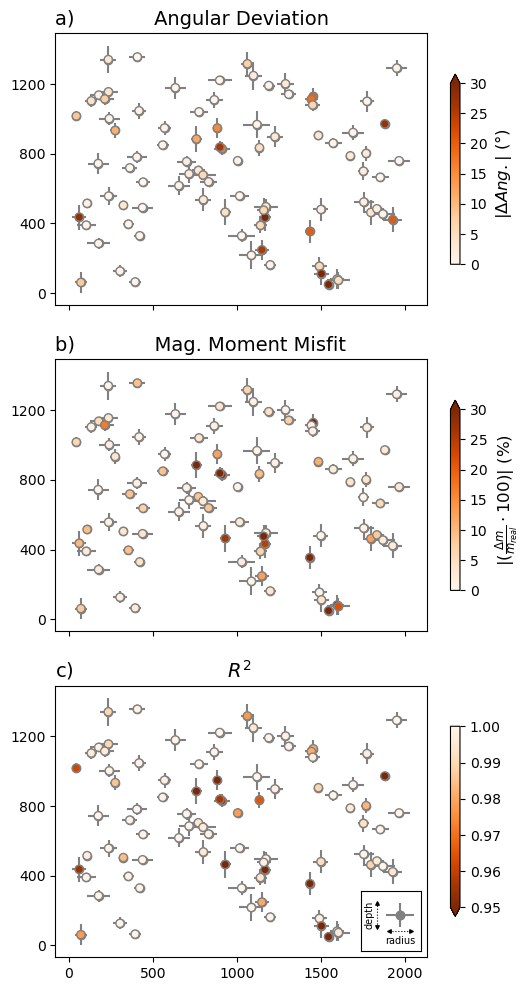

In [71]:
R2_filter = -np.inf
index_R2 = (df_win['R2']>=R2_filter)
h_R2=df_win[index_R2]

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3,1, figsize=(6,12))

# change size of the point according to the depth of sources
Size_Zc = ( (h_R2['Zc real (µm)'])/(h_R2['Zc real (µm)']).max() )*80
# change size of the point according to the radius of sources
Size_R = ((h_R2['R real (µm)'])/(h_R2['R real (µm)']).max() )*80


# plot original data
C_Ang = abs(h_R2['Angular deviation (°)'])
ax1.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img1 = ax1.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Ang, s=35, 
                   cmap='Oranges', edgecolor='gray', zorder=5)
color_bar1 = plt.colorbar(img1, ax=ax1, extend='max', 
                          shrink=0.7).set_label(label=r'$ |\Delta Ang.|$ (°)', size=12)
img1.set_clim(0, 30)
ax1.set_title('a)             Angular Deviation', fontsize=14, loc='left')




C_m = abs(h_R2['m residual (%)'])
ax2.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img2 = ax2.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_m, s=35, 
                   cmap='Oranges', edgecolor='gray')
color_bar2 = plt.colorbar(img2, ax=ax2, extend='max', 
                          shrink=0.7).set_label(label=r'$ | (\frac{\Delta m}{m_{real}} \cdot 100)| $ (%)',
                          size=12)
img2.set_clim(0, 30) 
ax2.set_title('b)             Mag. Moment Misfit', fontsize=14, loc='left')





C_R2 = h_R2['R2']
ax3.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
             fmt='o', zorder=0, color='gray')
img3 = ax3.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_R2, s=35, 
                   cmap='Oranges_r', edgecolor='gray')
color_bar3 = plt.colorbar(img3, ax=ax3,extend='min', 
                          shrink=0.7).set_label(label=r'', size=12)
img3.set_clim(0.95, 1.0)
ax3.set_title('c)                         $R^2$', fontsize=14, loc='left')


# plt.subplots_adjust(wspace=0.075)
plt.subplots_adjust(hspace=0.2)


# img4 = plt.imshow(corr, cmap='Oranges_r',  vmin=-1, vmax=1)

# sns.heatmap(corr, cmap='Oranges_r', annot=True, 
#             xticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
#             yticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
#            cbar=False)
# ax4.set_title('d)         Correlation Coeficient', fontsize=14, loc='left')
# color_bar4 = plt.colorbar(img4, ax=ax4, extend='neither', 
#                           shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1]).set_label(label=r'',
#                           size=12)


# ax4.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)
# ax3.set_ylabel('X (µm)', fontsize=10)
# ax3.set_xlabel('Y (µm)', fontsize=10)

ax1.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
ax1.set_yticks([0, 400, 800, 1200])

ax2.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
ax2.set_yticks(ticks=[0, 400, 800, 1200])

ax3.set_xticks([0, 500, 1000, 1500, 2000])
ax3.set_yticks([0, 400, 800, 1200])



left, bottom, width, height = [0.635, 0.115, 0.1, 0.05]
ax5 = fig.add_axes([left, bottom, width, height])
ax5.errorbar(0.5, 0.5, 0.5, 0.4, 
             fmt='o', zorder=0, color='gray')
ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
ax5.set_ylim(-1.0, 1.5)
ax5.set_xlim(-0.6, 1.1)

ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k', linewidth=0.8)
ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k', linewidth=0.8)
ax5.scatter(-0.15, -0.0, marker='v', color='k', s=6)
ax5.scatter(-0.15, 1.0,  marker='^', color='k', s=6)

ax5.scatter(0.2,-0.15, marker='<', color='k', s=6)
ax5.scatter(0.8,-0.15, marker='>', color='k', s=6)

ax5.text(0.08, -0.7, 'radius', color='k', fontsize=7)
ax5.text(-0.5, 0.01, 'depth', color='k', rotation='vertical', fontsize=7)

ax5.set_title('', loc='left')
# Eliminate upper and right axes
# ax5.spines['right'].set_color('none')
# ax5.spines['top'].set_color('none')
# ax5.spines['bottom'].set_color('none')
# ax5.spines['left'].set_color('none')
ax5.xaxis.set_ticks([])
ax5.yaxis.set_ticks([])

#save figure on the images folder
image_name = 'ComplexComparison'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

[[ 1.          0.17400164 -0.74333477  0.2957367  -0.31242424]
 [ 0.17400164  1.         -0.02561355  0.14205782 -0.15879079]
 [-0.74333477 -0.02561355  1.         -0.26751172  0.37292935]
 [ 0.2957367   0.14205782 -0.26751172  1.          0.18575122]
 [-0.31242424 -0.15879079  0.37292935  0.18575122  1.        ]]


<AxesSubplot:>

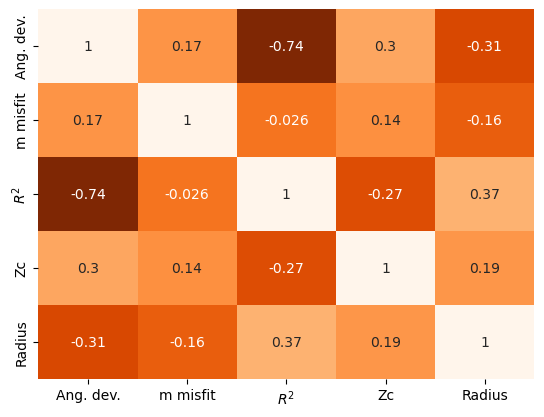

In [66]:
# correlation
ang_dev_ = abs(np.nan_to_num(h_R2['Angular deviation (°)']))
mag_mom_misfit_ = abs(np.nan_to_num(h_R2['m residual (%)']))
R2_ = np.nan_to_num(h_R2['R2'])
Zc_ = abs(np.nan_to_num(h_R2['Zc real (µm)']))
Radius_ = np.nan_to_num(h_R2['R real (µm)'])

R2, ang_dev, mag_mom_misfit, ZC, Radius = [], [], [], [], []

for i in range(len(R2_)):
    if R2_[i] != 0:
        R2 = np.append(R2, R2_[i])
        ang_dev = np.append(ang_dev, ang_dev_[i])
        mag_mom_misfit = np.append(mag_mom_misfit, mag_mom_misfit_[i])
        ZC = np.append(ZC, Zc_[i])
        Radius = np.append(Radius, Radius_[i])

corr = np.corrcoef( [ ang_dev, 
                      mag_mom_misfit,
                       R2,
                      ZC,
                      Radius])


print(corr)

plt.scatter(ang_dev, R2, c='r')
# plt.scatter(mag_mom_misfit, R2, c='b')
# plt.scatter(mag_mom_misfit, ang_dev, c='b')

import seaborn as sns

sns.heatmap(corr, cmap='Oranges_r', annot=True, 
            xticklabels=['Ang. dev.', 'm misfit', '$R^2$', 'Zc', 'Radius'],
            yticklabels=['Ang. dev.', 'm misfit', '$R^2$', 'Zc', 'Radius'],
           cbar=False)

# Third Figure

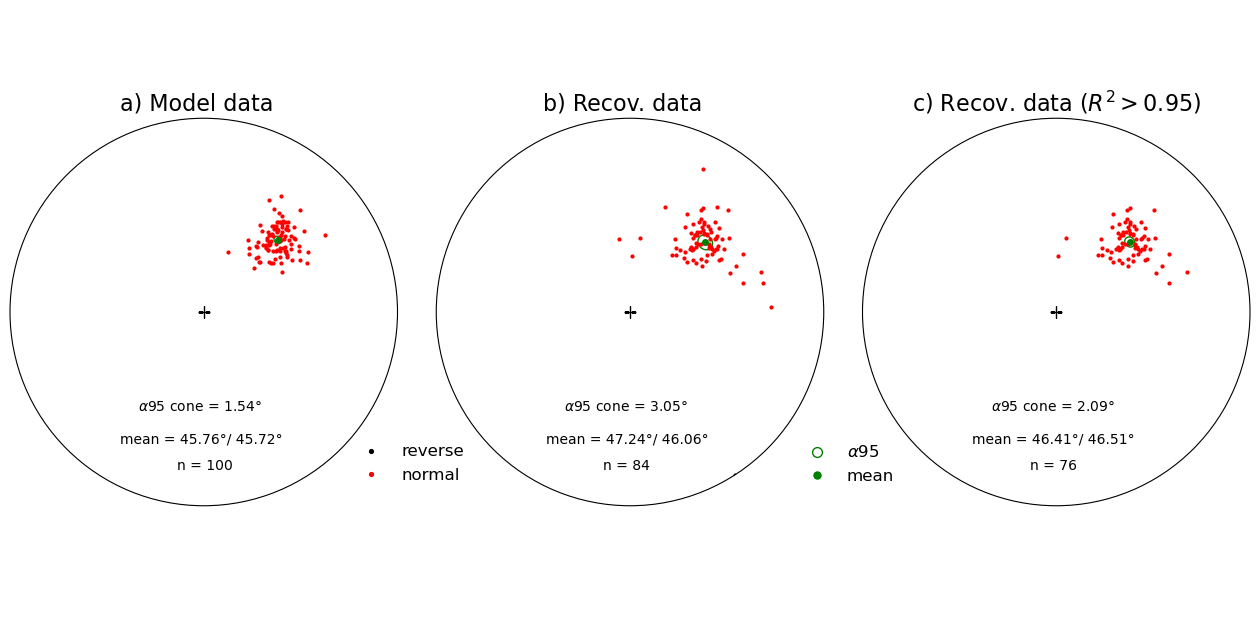

In [67]:
confidence=95

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(131, projection='stereonet')
ax2 = fig.add_subplot(132, projection='stereonet')
ax3 = fig.add_subplot(133, projection='stereonet')

####### Real directions #######
vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)
for i in range(len(D)):
    if I[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax1.line(abs(I[i]), D[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I, D, conf=confidence)

ax1.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax1.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax1.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax1.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax1.line(90,90, marker='+', color='k', markersize=8) # center mark
ax1.set_azimuth_ticks([])
# ax1.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax1.text(-0.45,-1.2, 'n = '+str(np.size(D)))

####### recovered directions #######
vector, stats = mpl.find_fisher_stats(I_FD_least, D_FD_least, conf=confidence)
for i in range(len(D_FD_least)):
    if I_FD_least[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax2.line(abs(I_FD_least[i]), D_FD_least[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I_FD_least, D_FD_least, conf=confidence)

ax2.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax2.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax2.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax2.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax2.line(90,90, marker='+', color='k', markersize=8) # center mark
ax2.set_azimuth_ticks([])
# ax2.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax2.text(-0.45,-1.2, 'n = '+str(np.size(D_FD_least)))

####### recovered directions filtered #######
vector, stats = mpl.find_fisher_stats(I_filtered, D_filtered, conf=confidence)
for i in range(len(D_filtered)):
    if I_filtered[i]>0:
        color = 'r'
        marker='.'
    else:
        color='k'
        marker='.'
    ax3.line(abs(I_filtered[i]), D_filtered[i], color=color, marker=marker, markersize=4)

vector, stats = mpl.find_fisher_stats(I_filtered, D_filtered, conf=confidence)

ax3.line(vector[0], vector[1], marker='o', color="green", markersize=4)
ax3.text(-0.95,-0.9, 'mean = '+str('{:.2f}'.format(vector[1]))+'°/ '+str('{:.2f}'.format(vector[0]))+'°')

# gives the a95 cone
ax3.cone(vector[0], vector[1], stats[1], facecolor="None", edgecolor="green")
ax3.text(-0.6,-0.7, r'$\alpha 95$ cone = '+str('{:.2f}'.format(stats[1]))+'°')

ax3.line(90,90, marker='+', color='k', markersize=8) # center mark
ax3.set_azimuth_ticks([])
# ax3.grid(which='both', linestyle=':', color='gray', alpha=0.4)
ax3.text(-0.45,-1.2, 'n = '+str(np.size(D_filtered)))

# legends
ax1.scatter([],[], label='reverse', color='k', marker='.', s=30, zorder=5)
ax1.scatter([],[], label='normal', color='r', marker='.', s=30, zorder=5)
ax1.legend(loc='upper left', bbox_to_anchor=(0.85, 0.2), frameon=False, fontsize=12)

ax2.scatter([],[], label=r'$\alpha 95$', color='w', marker='o', edgecolor='g', s=50, zorder=5)
ax2.scatter([],[], label=r'mean', color='g', marker='o', edgecolor='w', s=50, zorder=5)
ax2.legend(loc='upper left', bbox_to_anchor=(0.9, 0.2), frameon=False, fontsize=12)

# titles
ax1.set_title('a) Model data  ', fontsize=16, loc='center')
ax2.set_title('b) Recov. data  ', fontsize=16, loc='center')
ax3.set_title('c) Recov. data ($R^2 > %s$)'%cut_off_R2, fontsize=16, loc='center')

# ajust subplots spacing
fig.subplots_adjust(wspace=0.1)
plt.show()


#save figure on the images folder
image_name = 'ComplexStereo'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

In [68]:
# R2_filter = -np.inf
# index_R2 = (df_win['R2']>=R2_filter)
# h_R2=df_win[index_R2]

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(13,8))

# # change size of the point according to the depth of sources
# Size_Zc = ( (h_R2['Zc real (µm)'])/(h_R2['Zc real (µm)']).max() )*80
# # change size of the point according to the radius of sources
# Size_R = ((h_R2['R real (µm)'])/(h_R2['R real (µm)']).max() )*80


# # plot original data
# C_Dec = abs(h_R2['D residual (°)'])
# ax1.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img1 = ax1.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Dec, s=35, 
#                    cmap='Oranges', edgecolor='gray', zorder=5)
# color_bar1 = plt.colorbar(img1, ax=ax1, extend='max', 
#                           shrink=0.7).set_label(label=r'$ |\Delta D|$ (°)', size=12)
# img1.set_clim(0, 20)
# ax1.set_title('a)               Declination Misfit', fontsize=14, loc='left')




# C_Inc = abs(h_R2['I residual (°)'])
# ax2.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img2 = ax2.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Inc, s=35, 
#                    cmap='Oranges', edgecolor='gray')
# color_bar2 = plt.colorbar(img2, ax=ax2, extend='max', 
#                           shrink=0.7).set_label(label=r'$ |\Delta I|$ (°)', size=12)
# img2.set_clim(0, 20)
# ax2.set_title('b)               Inclination Misfit', fontsize=14, loc='left')





# C_m = abs(h_R2['m residual (%)'])
# ax3.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img3 = ax3.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_m, s=35, 
#                    cmap='Oranges', edgecolor='gray')
# color_bar3 = plt.colorbar(img3, ax=ax3, extend='max', 
#                           shrink=0.7).set_label(label=r'$ | (\frac{\Delta m}{m_{real}} \cdot 100)| $ (%)',
#                           size=12)
# img3.set_clim(0, 20) 
# ax3.set_title('c)             Mag. Moment Misfit', fontsize=14, loc='left')





# C_R2 = h_R2['R2']
# ax4.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img4 = ax4.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_R2, s=35, 
#                    cmap='Oranges_r', edgecolor='gray')
# color_bar4 = plt.colorbar(img4, ax=ax4,extend='min', 
#                           shrink=0.7).set_label(label=r'$R^2$ (Adm)', size=12)
# img4.set_clim(0.75, 1.0)
# ax4.set_title('d)                     $R^2$ Score', fontsize=14, loc='left')


# plt.subplots_adjust(wspace=0.1)
# plt.subplots_adjust(hspace=0.2)


# ax4.set_xlabel('Y (µm)', fontsize=10)
# ax1.set_ylabel('X (µm)', fontsize=10)
# ax3.set_ylabel('X (µm)', fontsize=10)
# ax3.set_xlabel('Y (µm)', fontsize=10)

# ax1.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
# ax1.set_yticks([0, 400, 800, 1200])
# ax2.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
# ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])
# ax3.set_xticks([0, 500, 1000, 1500, 2000])
# ax3.set_yticks([0, 400, 800, 1200])
# ax4.set_xticks([0, 500, 1000, 1500, 2000])
# ax4.set_yticks(ticks=[0, 400, 800, 1200], labels=[])


# left, bottom, width, height = [0.442, 0.44, 0.07, 0.11]
# ax5 = fig.add_axes([left, bottom, width, height])
# ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
#              fmt='o', zorder=0, color='gray')
# ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
# ax5.set_ylim(-1.0, 1.5)
# ax5.set_xlim(-0.6, 1.1)

# ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
# ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
# ax5.scatter(-0.15, -0.0, marker='v', color='k')
# ax5.scatter(-0.15, 1.0, marker='^', color='k')

# ax5.scatter(0.2,-0.15, marker='<', color='k')
# ax5.scatter(0.8,-0.15, marker='>', color='k')

# ax5.text(0.08, -0.7, 'radius', color='k', fontsize=11)
# ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

# ax5.set_title('', loc='left')
# # Eliminate upper and right axes
# # ax5.spines['right'].set_color('none')
# # ax5.spines['top'].set_color('none')
# # ax5.spines['bottom'].set_color('none')
# # ax5.spines['left'].set_color('none')
# ax5.xaxis.set_ticks([])
# ax5.yaxis.set_ticks([])

# #save figure on the images folder
# image_name = 'ComplexComparison'    
# import os
# my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
# fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

In [69]:
# R2_filter = -np.inf
# index_R2 = (df_win['R2']>=R2_filter)
# h_R2=df_win[index_R2]

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))

# # change size of the point according to the depth of sources
# Size_Zc = ( (h_R2['Zc real (µm)'])/(h_R2['Zc real (µm)']).max() )*80
# # change size of the point according to the radius of sources
# Size_R = ((h_R2['R real (µm)'])/(h_R2['R real (µm)']).max() )*80


# # plot original data
# C_Ang = abs(h_R2['Angular deviation (°)'])
# ax1.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img1 = ax1.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_Ang, s=35, 
#                    cmap='Oranges', edgecolor='gray', zorder=5)
# color_bar1 = plt.colorbar(img1, ax=ax1, extend='max', 
#                           shrink=0.7).set_label(label=r'$ |\Delta Ang.|$ (°)', size=12)
# img1.set_clim(0, 30)
# ax1.set_title('a)           Angular Deviation', fontsize=14, loc='left')




# C_m = abs(h_R2['m residual (%)'])
# ax2.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img2 = ax2.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_m, s=35, 
#                    cmap='Oranges', edgecolor='gray')
# color_bar2 = plt.colorbar(img2, ax=ax2, extend='max', 
#                           shrink=0.7).set_label(label=r'$ | (\frac{\Delta m}{m_{real}} \cdot 100)| $ (%)',
#                           size=12)
# img2.set_clim(0, 30) 
# ax2.set_title('b)           Mag. Moment Misfit', fontsize=14, loc='left')





# C_R2 = h_R2['R2']
# ax3.errorbar(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], Size_Zc, Size_R, 
#              fmt='o', zorder=0, color='gray')
# img3 = ax3.scatter(h_R2['Yc real (µm)'], h_R2['Xc real (µm)'], c=C_R2, s=35, 
#                    cmap='Oranges_r', edgecolor='gray')
# color_bar3 = plt.colorbar(img3, ax=ax3,extend='min', 
#                           shrink=0.7).set_label(label=r'', size=12)
# img3.set_clim(0.9, 1.0)
# ax3.set_title('c)                        $R^2$', fontsize=14, loc='left')


# plt.subplots_adjust(wspace=0.075)
# plt.subplots_adjust(hspace=0.3)


# # img4 = plt.imshow(corr, cmap='Oranges_r',  vmin=-1, vmax=1)

# sns.heatmap(corr, cmap='Oranges_r', annot=True, 
#             xticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
#             yticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
#            cbar=False)
# ax4.set_title('d)         Correlation Coeficient', fontsize=14, loc='left')
# color_bar4 = plt.colorbar(img4, ax=ax4, extend='neither', 
#                           shrink=0.7, ticks=[-1, -0.5, 0, 0.5, 1]).set_label(label=r'',
#                           size=12)


# # ax4.set_xlabel('Y (µm)', fontsize=10)
# # ax1.set_ylabel('X (µm)', fontsize=10)
# # ax3.set_ylabel('X (µm)', fontsize=10)
# # ax3.set_xlabel('Y (µm)', fontsize=10)

# ax1.set_xticks(ticks=[0, 500, 1000, 1500, 2000])
# ax1.set_yticks([0, 400, 800, 1200])
# # ax2.set_xticks(ticks=[0, 500, 1000, 1500, 2000], labels=[])
# ax2.set_yticks(ticks=[0, 400, 800, 1200], labels=[])
# # ax3.set_xticks([0, 500, 1000, 1500, 2000])
# ax3.set_yticks([0, 400, 800, 1200], labels=[])
# # ax4.set_xticks([0, 500, 1000, 1500, 2000])
# # ax4.set_yticks(ticks=[0, 400, 800, 1200], labels=[])


# left, bottom, width, height = [0.44, 0.44, 0.07, 0.11]
# ax5 = fig.add_axes([left, bottom, width, height])
# ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
#              fmt='o', zorder=0, color='gray')
# ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
# ax5.set_ylim(-1.0, 1.5)
# ax5.set_xlim(-0.6, 1.1)

# ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
# ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
# ax5.scatter(-0.15, -0.0, marker='v', color='k')
# ax5.scatter(-0.15, 1.0, marker='^', color='k')

# ax5.scatter(0.2,-0.15, marker='<', color='k')
# ax5.scatter(0.8,-0.15, marker='>', color='k')

# ax5.text(0.08, -0.7, 'radius', color='k', fontsize=11)
# ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

# ax5.set_title('', loc='left')
# # Eliminate upper and right axes
# # ax5.spines['right'].set_color('none')
# # ax5.spines['top'].set_color('none')
# # ax5.spines['bottom'].set_color('none')
# # ax5.spines['left'].set_color('none')
# ax5.xaxis.set_ticks([])
# ax5.yaxis.set_ticks([])

# #save figure on the images folder
# image_name = 'Nova'    
# import os
# my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
# fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=600, facecolor='w', bbox_inches='tight')

[[ 1.          0.17400164 -0.74333477]
 [ 0.17400164  1.         -0.02561355]
 [-0.74333477 -0.02561355  1.        ]]


<AxesSubplot:>

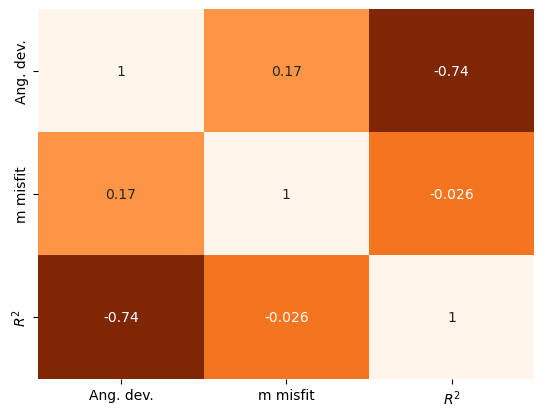

In [70]:
# correlation
ang_dev_ = abs(np.nan_to_num(h_R2['Angular deviation (°)']))
mag_mom_misfit_ = abs(np.nan_to_num(h_R2['m residual (%)']))
R2_ = np.nan_to_num(h_R2['R2'])

R2, ang_dev, mag_mom_misfit = [], [], []

for i in range(len(R2_)):
    if R2_[i] != 0:
        R2 = np.append(R2, R2_[i])
        ang_dev = np.append(ang_dev, ang_dev_[i])
        mag_mom_misfit = np.append(mag_mom_misfit, mag_mom_misfit_[i])

corr = np.corrcoef( [ ang_dev, 
                      mag_mom_misfit,
                       R2])


print(corr)

plt.scatter(ang_dev, R2, c='r')
# plt.scatter(mag_mom_misfit, R2, c='b')
# plt.scatter(mag_mom_misfit, ang_dev, c='b')

import seaborn as sns

sns.heatmap(corr, cmap='Oranges_r', annot=True, 
            xticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
            yticklabels=['Ang. dev.', 'm misfit', '$R^2$'],
           cbar=False)